# Make your variogram object

In [1]:
import pandas as PD
import geopandas as GPD
import numpy as NP
import matplotlib.pyplot as PLT
from tqdm import tqdm as TQDM
from scipy.spatial.distance import cdist
from scipy.optimize import least_squares

## 1. Define variogram functions

In [2]:
class variogram(object):
    """
    Variogram estimator 
    """
    def __init__(self, lag, model=None):
        """
        Initialization model parameters
        [Input]
            lag     : float, width of bin of binned variogram PDF
            model   : callable, PDF of variogram for fitting
        """
        ## Local parameters ##
        self.model = model
        self.lag = lag

        ## Local variables ##
        # lag edges
        self.lags_edge = []
        # sum of distance in lag range
        self.lags_d = []
        # number of pair in lag range 
        self.lags_n = []
        # sum of variance in lag range
        self.lags_v = []
        # number of fills in lag range
        self.nfills = []
        # fitted parameters of variogram model
        self.fitted_parms = None
    
    ## Callable variables ##
    @property
    def sill(self):
        return self.fitted_parms[0] + self.fitted_parms[2] if self.fitted_parms is not None else None

    @property
    def range(self):
        return self.fitted_parms[1] if self.fitted_parms is not None else None

    @property
    def nugget(self):
        return self.fitted_parms[2] if self.fitted_parms is not None else None

    @property
    def semivariograms(self):
        return NP.divide(self.lags_v, self.lags_n, out=NP.zeros_like(self.lags_v), where=NP.array(self.lags_n)!=0)

    @property
    def lags(self):
        lags = NP.divide(self.lags_d, self.lags_n, out=NP.zeros_like(self.lags_d), where=NP.array(self.lags_n)!=0)
        msk = (lags == 0)
        lags[msk] = NP.array(self.lags_edge)[msk]
        return lags
    
    ## Functions ##
    ## predict
    def predict(self, X):
        return self.model(X, self.fitted_parms) 
    
    ## Fitting fuctions ##
    def fit(self, X, y, x0=None, bounds=None, fit_range=None, loss='soft_l1', batch_size=100, metric='euclidean'):
        return fit(self, X, y, x0=x0, bounds=bounds, fit_range=fit_range, loss=loss, batch_size=batch_size, metric=metric)
    
    def calculate(self, X, y, batch_size=100, metric='euclidean'):
        return calculate(self, X, y, batch_size=batch_size, metric=metric)
    
    def update_fit(self, x0=None, bounds=None, fit_range=None, loss='soft_l1'):
        return update_fit(self, x0=x0, bounds=bounds, fit_range=fit_range, loss=loss)
        
    def initial_fitparams(self, x0=None, bounds=None):
        return initial_fitparams(self, x0=x0, bounds=bounds)
    
    def _cost(self, params):
        return _cost(self, params)
        
        
    ## Display functions ##
    def summary(self):
        return summary(self)
    
    def plot(self):
        return plot(self)

## 2. Load Rive Meuse data

In [3]:
gdf = GPD.read_file('./data/muese.shp')
gdf.head()

,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,x,y,geometry
0,11.7,85.0,299.0,1022.0,7.909,0.001358,13.6,1,1,1,Ah,50.0,181072.0,333611.0,POINT (5.758536241675762 50.99156215667816)
1,8.6,81.0,277.0,1141.0,6.983,0.012224,14.0,1,1,1,Ah,30.0,181025.0,333558.0,POINT (5.757863018200728 50.99108790288359)
2,6.5,68.0,199.0,640.0,7.800,0.103029,13.0,1,1,1,Ah,150.0,181165.0,333537.0,POINT (5.759855417830628 50.99089274333686)
3,2.6,81.0,116.0,257.0,7.655,0.190094,8.0,1,2,0,Ga,270.0,181298.0,333484.0,POINT (5.761745770023087 50.99041023559325)
4,2.8,48.0,117.0,269.0,7.480,0.277090,8.7,1,2,0,Ah,380.0,181307.0,333330.0,POINT (5.761862707698853 50.98902557091748)


## 3. Calculate variogram with input 'x', 'y' and 'lead'

Defination of variogram is as

$$ 
V(\mathbf{d})=\frac{1}{N(\mathbf{d})}\sum_{\substack{\mathbf{s}_j = \mathbf{s}_i + \mathbf{d} \\ i\neq j}}(z(\mathbf{s}_i)-z(\mathbf{s}_j))^2 
$$

Since $(z(\mathbf{s}_i)-z(\mathbf{s}_j))$ = $(z(\mathbf{s}_j)-z(\mathbf{s}_i))$, the semivariogram $\gamma(\mathbf{d}) = V(\mathbf{d})/2$ is to avoid the dobule count.

In [4]:
def calculate(self, X, y, batch_size=100, metric='euclidean'):
    """
    Calculate semi-variogram and make binned lags
    [Input]
        X          : array-like, input features
        y          : array-like, target/interested values
        batch_size : int, number of data in each batch (default 100)
        metric     : str, distance algorithm for measuring pair. See options in scipy.spatial.distance.cdist (default euclidean)
    """
    ## make input type to numpy.array ##
    X = NP.atleast_1d(X)
    y = NP.atleast_1d(y)

    ## Make X, y two 2-D ##
    if X.ndim < 2: X = X[:, NP.newaxis]
    if y.ndim < 2: y = y[:, NP.newaxis]

    ## create batch index to avoid memory over consuming ##
    n = y.shape[0]
    n_batch = int(n/batch_size)
    n_batch = n_batch + 1 if n_batch < n/batch_size else n_batch

    ## calculate semi-variogram ##
    for i in range(n_batch):
        i = i*batch_size
        j = i + batch_size

        ## calucalte distance (lag) and semivariance of pair
        d = NP.triu(cdist(X[i:j, :], X[i:, :], metric=metric))
        v = NP.triu(cdist(y[i:j, :], y[i:, :], metric='sqeuclidean')) # no 1/2 since no double count
        
        ## flat matrix
        d = d.flatten()
        v = v.flatten()

        ## distribute semivariance and lags to lag's range (bins)
        nlags = int(max(d)/self.lag)
        nlags = nlags + 1 if nlags != 1 else nlags
        for b in range(nlags):
            edge = b*self.lag
            msk = (d >= edge) & (d < edge + self.lag)
            if edge in self.lags_edge:
                self.nfills[b] += 1
                self.lags_d[b] += sum(d[msk])
                self.lags_n[b] += len(d[msk])
                self.lags_v[b] += sum(v[msk])
            else:
                # first fill
                self.nfills.append(1)
                self.lags_edge.append(edge)
                self.lags_d.append(sum(d[msk]))
                self.lags_n.append(len(d[msk]))
                self.lags_v.append(sum(v[msk]))

In [5]:
## Input rive muese data to variogram object
VAR = variogram(lag=100)
VAR.calculate(gdf[['x', 'y']], gdf['lead'])

## 4. Check the shape of variogram and deside the fitting function

In [6]:
def plot(self):
    """
    Displays variogram model with the actual binned data.
    """
    fig, axes = PLT.subplots(figsize=PLT.gcf().get_size_inches())

    ## data point ##
    axes.set_xlim([min(self.lags_edge), max(self.lags_edge)])
    axes.set_ylim([0, max(self.semivariograms)*1.1])
    axes.plot(self.lags, self.semivariograms, 'k.', markersize=10)

    ## fitting line ##
    if self.fitted_parms is not None:
        axes.plot(self.lags, self.model(self.lags, self.fitted_parms), 'r-')
        if self.fit_range is not None:
            axes.plot([self.fit_range[0], self.fit_range[0]], axes.get_ylim(), 'r--' )
            axes.plot([self.fit_range[1], self.fit_range[1]], axes.get_ylim(), 'r--' )

<Figure size 720x432 with 0 Axes>

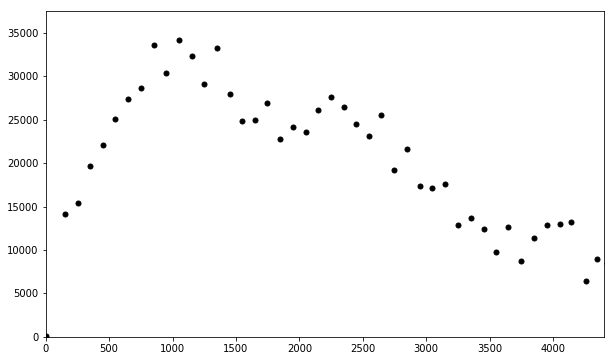

In [7]:
PLT.figure(figsize=[10,6])
VAR.plot()

In [8]:
def variogram_spherical(d, pars):
    """Spherical model, pars[3] = [psill, range, nugget]
                             3 * d           d^3  
    x <= [2] : y = [0] * ( ---------  -  ---------- ) + [2]
                            2 * [1]       2 * [1]^3
    x > [2]  : y = [0] + [2]
    """
    psill = float(pars[0])
    prange = float(pars[1])
    pnugget = float(pars[2])
    return NP.piecewise( d, 
                        [d <= prange, d > prange],
                        [lambda x: psill * ((3.*x)/(2.*prange) - (x**3.)/(2.*prange**3.)) + pnugget, 
                         psill + pnugget])

## 5. Make fitting function

In [9]:
def update_fit(self, x0=None, bounds=None, fit_range=None, loss='soft_l1'):
    """
    Fit binned semi-variogram with input model (overwrite fitting results)
    [Input]
        x0         : array-like (3,), initial parameters (sill, range, nugget).
                            If None, the default will be provided by statistical estimation. (default None)
        bounds     : array-like (2,3), boundary of fitting parameter ((lower_bound), (upper_bound)).
                            Each bound includes (sill, range, nugget). If None, the default will be provided
                            by statistical estimation. (default None)
        fit_range  : array-like (2,), minmum and maximum lag for fitting (default None)
        loss       : str, loss function for fitting (defaut 'soft_l1')
    """
    if self.model is None:
        print("Error : no model found")
        return self

    ## Fit with least square ##
    self.fit_range = fit_range
    ## parameter initialization
    self.initial_fitparams(x0, bounds)
    ## fit with least squares method
    self.results = least_squares(fun=self._cost, x0=self.x0, bounds=self.bounds, loss=loss)
    ## obtain fitted results
    self.fitted_parms = self.results.x
    self.fitted_semivariograms = self.model(NP.atleast_1d(self.lags), self.fitted_parms)

    ## fitting metric ##
    self.r2 = 1 - sum((self.fitted_semivariograms[self.msk] - self.semivariograms[self.msk])**2)/sum((self.semivariograms[self.msk] - self.semivariograms[self.msk].mean())**2)
    #self.chi2 = sum(((self.semivariograms[self.msk] - self.fitted_semivariograms[self.msk])/self.error[self.msk])**2)
    #self.chi2ndf = self.chi2/(len(self.semivariograms[self.msk]) - 3)

In [10]:
## define require functions
def initial_fitparams(self, x0=None, bounds=None):
    """
    Initializae fitting parameters for variogram models
    [Input]
        x0     : array-like (3,), initial parameters (sill, range, nugget).
                 If None, the default will be provided by statistical estimation. (default None)
        bounds : array-like (2,3), boundary of fitting parameter ((lower_bound), (upper_bound)).
                 Each bound includes (sill, range, nugget). If None, the default will be provided
                 by statistical estimation. (default None)
    """
    if x0 is None:
        self.x0 = [NP.amax(self.semivariograms)-NP.amin(self.semivariograms),
                   0.25*self.lags[self.semivariograms == NP.amax(self.semivariograms)][0],
                   NP.amin(self.semivariograms)]
    else:
        self.x0 = x0

    if bounds is None:
        self.bounds = ([0., 0., 0.],
                       [10.*NP.amax(self.semivariograms), NP.amax(self.lags), NP.amax(self.semivariograms)])
    else:
        self.bounds = bounds

def _cost(self, params):
    """
    Cost function for least square method
    [Input]
    params : array-like, input fitted parameters from least_square function
    """
    ## make fitting range data mask ##
    if self.fit_range is not None:
        self.msk = (NP.atleast_1d(self.lags_edge) >= self.fit_range[0]) & (NP.atleast_1d(self.lags_edge) <= self.fit_range[1])
    else:
        self.msk = NP.full(NP.atleast_1d(self.lags_edge).shape, True)
    ## Get residual ##
    cost = self.model(NP.atleast_1d(self.lags)[self.msk], params) - NP.atleast_1d(self.semivariograms)[self.msk]
    return cost

<Figure size 720x432 with 0 Axes>

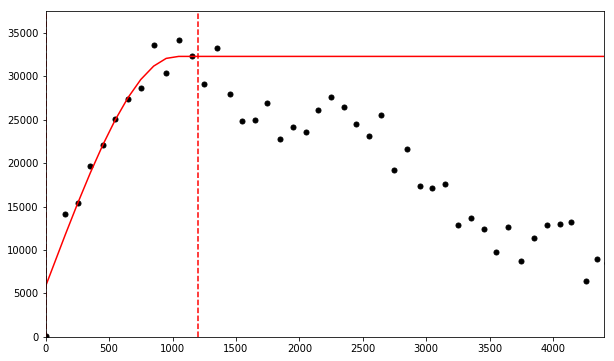

In [11]:
## fit
VAR.model = variogram_spherical
VAR.update_fit(fit_range=[0,1200])
PLT.figure(figsize=[10,6])
VAR.plot()

In [12]:
def summary(self):
    """
    Summary fitted results
    """
    print("Sill %f"%(self.sill))
    print("Range %f"%(self.range))
    print("Nugget %f"%(self.nugget))
    if self.fitted_parms is not None:
        print("Fit r2 %f"%(self.r2))
VAR.summary()

Sill 32290.490490
Range 1029.294589
Nugget 5850.662922
Fit r2 0.944005


## Optional : Aggregate fitting and calculation function

In [13]:
def fit(self, X, y, x0=None, bounds=None, fit_range=None, loss='soft_l1', batch_size=100, metric='euclidean'):
    """
    Fit binned semi-variogram with input model (overwrite binned semi-variogram and fitting results)
    [Input]
        X          : array-like, input features
        y          : array-like, target/interested values
        x0         : array-like (3,), initial parameters (sill, range, nugget).
                            If None, the default will be provided by statistical estimation. (default None)
        bounds     : array-like (2,3), boundary of fitting parameter ((lower_bound), (upper_bound)).
                            Each bound includes (sill, range, nugget). If None, the default will be provided
                            by statistical estimation. (default None)
        fit_range  : array-like (2,), minmum and maximum lag for fitting (default None)
        loss       : str, loss function for fitting (defaut 'soft_l1')
        batch_size : int, number of data in each batch (default 100)
        metric     : str, distance algorithm for measuring pair. See options in scipy.spatial.distance.cdist (default 'euclidean')
    """
    self.lags_edge = []
    self.lags_d = []
    self.lags_n = []
    self.lags_v = []
    self.lags_e = []
    self.nfills = []
    self.fitted_parms = None
    ## calculate binned semi-variogram
    self.calculate(X, y, batch_size, metric)
    ## fit the binned semi-variogram
    self.update_fit(x0, bounds, fit_range, loss)